In [510]:
import torch
from torch import nn
from torch.utils.data import DataLoader, ConcatDataset, Dataset
from torchvision import datasets
from torchvision.transforms import Compose, ToTensor, Lambda
from torchvision.transforms.functional import rotate, hflip
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import pandas as pd

In [511]:
class MathSymbolsDataset(Dataset):
    def __init__(self, img_labels, transform=None, target_transform=None):
        self.img_labels = img_labels
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = self.img_labels.iloc[idx, 0]

        im = cv2.imread(img_path)

        im = cv2.bitwise_not(im)
        im = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)

        #     cnts = cv2.findContours(im, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        #     cnts = cnts[0] if len(cnts) == 2 else cnts[1]
        #     for c in cnts:
        #         cv2.drawContours(im, [c], -1, (255,255,255), thickness=2)

        kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (4, 4))
        im = cv2.dilate(im, kernel, iterations=1)

        im = cv2.resize(im, (20, 20))
        border = 4
        im = cv2.copyMakeBorder(
            im, border, border, border, border, cv2.BORDER_CONSTANT, value=(0, 0, 0)
        )

        image = torch.from_numpy(im.astype("float32")).unsqueeze(0)

        label = self.img_labels.iloc[idx, 1]
        label = torch.tensor(label).type(torch.LongTensor)
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

In [512]:
# name = "emnistbyclass"
# name = "mnist"
# name = "mathsymbols"
# name = "mnist_mathsymbols"
name = "emnistbyclass_mathsymbols"

# EMNIST dataset
split = "byclass"
# split = 'bymerge'
# split = 'balanced'
# split = 'letters'
# split = 'digits'
# split = "mnist"
emnist_train_data = datasets.EMNIST(
    root="data",
    split=split,
    train=True,
    download=True,
    transform=Compose([lambda img: rotate(img, -90), lambda img: hflip(img), ToTensor()]),
    target_transform=Lambda(lambda y: torch.tensor(y)),
)
emnist_test_data = datasets.EMNIST(
    root="data",
    split=split,
    train=False,
    download=True,
    transform=Compose([lambda img: rotate(img, -90), lambda img: hflip(img), ToTensor()]),
    target_transform=Lambda(lambda y: torch.tensor(y)),
)

# Math Symbols dataset
math_symbols_root = "data/math_symbols"
math_symbols = ["-", "!", "(", ")", ",", "[", "]", "+", "=", "forward_slash", "gt", "lt", "times"]
print("Num math symbols:", len(math_symbols))
data = []
for i, symbol in enumerate(math_symbols):
    root = f"{math_symbols_root}/{symbol}"
    files = os.listdir(root)
    for file in files:
        path = f"{root}/{file}"
        label = i
        data.append([path, label])
data = np.array(data)
img_labels = pd.DataFrame(columns=["path", "label"])
img_labels["path"] = data[:, 0]
img_labels["label"] = data[:, 1].astype(int)
if name == "mnist_mathsymbols":
    img_labels["label"] = img_labels["label"] + 10
elif "mnist" in name:
    img_labels["label"] = img_labels["label"] + 62
display(img_labels)
display(img_labels.info())
math_symbols_dataset = MathSymbolsDataset(img_labels)
print("Math symbols dataset:", len(math_symbols_dataset), math_symbols_dataset[0][0].size())

math_symbols_train_size = int(0.8 * len(math_symbols_dataset))
math_symbols_test_size = len(math_symbols_dataset) - math_symbols_train_size
math_symbols_train_data, math_symbols_test_data = torch.utils.data.random_split(
    math_symbols_dataset, [math_symbols_train_size, math_symbols_test_size]
)

Num math symbols: 13


,path,label
0,data/math_symbols/-/-_100005.jpg,62
1,data/math_symbols/-/-_100007.jpg,62
2,data/math_symbols/-/-_100009.jpg,62
3,data/math_symbols/-/-_100015.jpg,62
4,data/math_symbols/-/-_100021.jpg,62
...,...,...
109806,data/math_symbols/times/times_95436.jpg,74
109807,data/math_symbols/times/times_95489.jpg,74
109808,data/math_symbols/times/times_9589.jpg,74
109809,data/math_symbols/times/times_9755.jpg,74


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 109811 entries, 0 to 109810
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   path    109811 non-null  object
 1   label   109811 non-null  int32 
dtypes: int32(1), object(1)
memory usage: 1.3+ MB


None

Math symbols dataset: 109811 torch.Size([1, 28, 28])


In [513]:
# total_samples = 0
# for symbol in math_symbols:
#     path = f'{math_symbols_root}/{symbol}'
#     files = os.listdir(path)
#     total_samples += len(files)
#     idx = np.random.randint(0, len(files))
#     file = f'{path}/{files[idx]}'

#     im = cv2.imread(file)

#     im = cv2.bitwise_not(im)
#     im = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)

# #     cnts = cv2.findContours(im, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
# #     cnts = cnts[0] if len(cnts) == 2 else cnts[1]
# #     for c in cnts:
# #         cv2.drawContours(im, [c], -1, (255,255,255), thickness=2)

#     kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (4,4))
#     im = cv2.dilate(im, kernel, iterations=1)

#     im = cv2.resize(im, (20, 20))
#     border = 4
#     im = cv2.copyMakeBorder(im, border, border, border, border, cv2.BORDER_CONSTANT, value=(0,0,0))
#     print(im.shape)
#     plt.imshow(im, cmap="gray")
#     print(file)

# print('total samples:', total_samples)

In [514]:
if "mnist" in name and "symbols" not in name:
    train_data = emnist_train_data
    test_data = emnist_test_data
elif "mnist" not in name and "symbols" in name:
    train_data = math_symbols_train_data
    test_data = math_symbols_test_data
else:
    train_data = ConcatDataset([emnist_train_data, math_symbols_train_data])
    test_data = ConcatDataset([emnist_test_data, math_symbols_test_data])

In [515]:
if name == "mnist_mathsymbols":
    class_names = [str(num) for num in range(10)] + math_symbols
elif "mnist" in name and "symbols" not in name:
    class_names = (
        [str(num) for num in range(10)]
        + [chr(capital) for capital in range(ord("A"), ord("Z") + 1)]
        + [chr(lower) for lower in range(ord("a"), ord("z") + 1)]
    )
elif "mnist" not in name and "symbols" in name:
    class_names = math_symbols
else:
    class_names = (
        [str(num) for num in range(10)]
        + [chr(capital) for capital in range(ord("A"), ord("Z") + 1)]
        + [chr(lower) for lower in range(ord("a"), ord("z") + 1)]
        + math_symbols
    )
print(len(class_names))
print(class_names)

75
['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '-', '!', '(', ')', ',', '[', ']', '+', '=', 'forward_slash', 'gt', 'lt', 'times']


Label: L


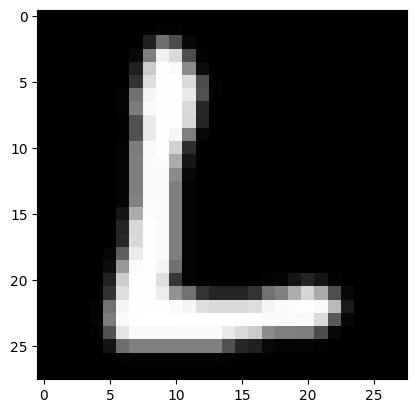

In [516]:
idx = np.random.randint(0, len(train_data))
sample_img, sample_label = train_data[idx]
plt.imshow(sample_img.reshape(28, 28), cmap="gray")
print("Label:", class_names[sample_label])

In [517]:
batch_size = 64

train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=0)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=True, num_workers=0)

# for X, y in test_dataloader:
#     print(f"Shape of X [N, C, H, W]: {X.shape}")
#     print(f"Shape of y: {y.shape} {y.dtype}")
#     break

n_classes = len(class_names)
print("n_classes:", n_classes)

n_classes: 75


In [518]:
device = (
    "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
)
print(f"Using {device} device")


class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3),
            nn.ReLU(),
            nn.BatchNorm2d(num_features=32),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3),
            nn.ReLU(),
            nn.BatchNorm2d(num_features=32),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=5, stride=1, padding="same"),
            nn.ReLU(),
            nn.BatchNorm2d(num_features=32),
            nn.Dropout(p=0.4),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.ReLU(),
            nn.BatchNorm2d(num_features=64),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3),
            nn.ReLU(),
            nn.BatchNorm2d(num_features=64),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=5, stride=1, padding="same"),
            nn.ReLU(),
            nn.BatchNorm2d(num_features=64),
        )
        self.classifier = nn.Sequential(
            nn.Dropout(p=0.4),
            nn.Linear(in_features=64 * 20 * 20, out_features=128),
            nn.ReLU(),
            nn.BatchNorm1d(num_features=128),
            nn.Dropout(p=0.4),
            nn.Linear(in_features=128, out_features=n_classes),
        )

    def forward(self, x):
        out = self.features(x)
        out = out.view(out.size(0), -1)
        out = self.classifier(out)
        return out


model = CNN().to(device)
print(model)

Using cuda device
CNN(
  (features): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
    (4): ReLU()
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Conv2d(32, 32, kernel_size=(5, 5), stride=(1, 1), padding=same)
    (7): ReLU()
    (8): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): Dropout(p=0.4, inplace=False)
    (10): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (11): ReLU()
    (12): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (14): ReLU()
    (15): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (16): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1), padding=same)

In [519]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-1)

In [520]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        pred = model(X)
        loss = loss_fn(pred, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [521]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    preds = []
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            preds += pred.argmax(1).tolist()
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return preds

In [522]:
epochs = 1
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 4.582236  [   64/785780]
loss: 1.344387  [ 6464/785780]
loss: 0.924367  [12864/785780]
loss: 0.890122  [19264/785780]
loss: 0.765667  [25664/785780]
loss: 0.668570  [32064/785780]
loss: 0.932734  [38464/785780]
loss: 0.678241  [44864/785780]
loss: 0.658680  [51264/785780]
loss: 0.718621  [57664/785780]
loss: 0.646751  [64064/785780]
loss: 0.509588  [70464/785780]
loss: 0.708094  [76864/785780]
loss: 0.579620  [83264/785780]
loss: 0.646760  [89664/785780]
loss: 0.568232  [96064/785780]
loss: 0.398558  [102464/785780]
loss: 0.575463  [108864/785780]
loss: 0.419699  [115264/785780]
loss: 0.721029  [121664/785780]
loss: 0.553227  [128064/785780]
loss: 0.420183  [134464/785780]
loss: 0.359552  [140864/785780]
loss: 0.609379  [147264/785780]
loss: 0.362872  [153664/785780]
loss: 0.647994  [160064/785780]
loss: 0.402719  [166464/785780]
loss: 0.452747  [172864/785780]
loss: 0.618336  [179264/785780]
loss: 0.446103  [185664/785780]
loss: 0.350634  

In [523]:
torch.save(model.state_dict(), f"model_{name}.pth")

In [524]:
model = CNN()
model.load_state_dict(torch.load(f"model_{name}.pth"))
model = model.to(device)

Predicted: "F", Actual: "F"


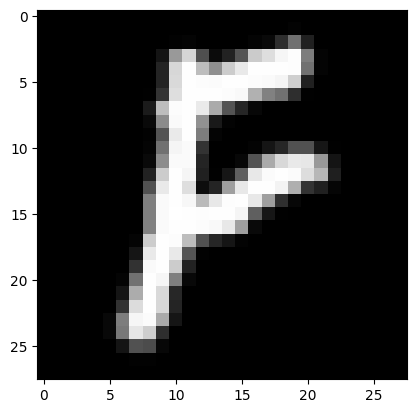

In [574]:
model.eval()
idx = np.random.randint(0, len(test_data))
x, y = test_data[idx]
with torch.no_grad():
    x = x.unsqueeze(0)
    pred = model(x.to(device))
    predicted, actual = class_names[pred[0].argmax(0)], class_names[y]
    print(f'Predicted: "{predicted}", Actual: "{actual}"')
plt.imshow(x.reshape(28, 28), cmap="gray")

In [526]:
preds = test(test_dataloader, model, loss_fn)

Test Error: 
 Accuracy: 88.1%, Avg loss: 0.325331 

